In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
ticker = "MRF.NS" 
start_date = "2013-07-06"  
end_date = "2023-07-06"  

data = yf.download(ticker, start=start_date, end=end_date)
df = data[['Open', 'High', 'Low', 'Close']].copy()
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2013-07-08,12225.00,12299.950195,12050.000000,12207.900391
2013-07-09,12498.00,12528.700195,12260.000000,12475.950195
2013-07-10,12450.00,12675.000000,12435.000000,12501.150391
2013-07-11,12412.00,12744.599609,12412.000000,12661.400391
2013-07-12,12701.00,12790.000000,12523.799805,12605.200195
...,...,...,...,...
2023-06-28,99591.25,99591.250000,99591.250000,99591.250000
2023-06-30,100598.00,101648.296875,100020.250000,101260.500000
2023-07-03,101073.00,101888.000000,99600.000000,99899.453125


In [3]:
# Calculate MACD
def calculate_macd(df, short_period=12, long_period=26, signal_period=9):
    df['EMA_short'] = df['Close'].ewm(span=short_period, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_period, adjust=False).mean()
    df['MACD'] = df['EMA_short'] - df['EMA_long']
    df['Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()

calculate_macd(df)

In [4]:
# Identify Double Top pattern
def identify_double_top(df, lookback=5):
    df['High_shifted'] = df['High'].shift(1)
    df['Low_shifted'] = df['Low'].shift(1)
    df['Double_Top'] = ((df['High'] > df['High_shifted']) &
                        (df['High_shifted'] < df['High_shifted'].shift(1)) &
                        (df['Low'] < df['Low_shifted']))
    df.drop(['High_shifted', 'Low_shifted'], axis=1, inplace=True)

identify_double_top(df)

In [5]:
# Implement trading strategy
capital = 100000  # Initial capital
position = 0  # 0 for no position, 1 for long position
stop_loss = 0  # Stop-loss level
take_profit = 0  # Take-profit level
returns = []  # List to track daily returns
buy_dates = []
sell_dates = []

for i in range(1, len(df)):
    # Buy signal
    if df['MACD'].iloc[i] > df['Signal'].iloc[i] and df['Double_Top'].iloc[i]:
        if position == 0:
            position = 1
            stop_loss = df['Low'].iloc[i]
            take_profit = df['High'].iloc[i] + (df['High'].iloc[i] - stop_loss) * 2
            buy_dates.append(df.index[i])
            returns.append(0)  # Add a dummy return value
            print('Buy at:', df['Close'].iloc[i])

    # Sell signal
    elif position == 1 and (df['Low'].iloc[i] < stop_loss or df['High'].iloc[i] > take_profit):
        position = 0
        exit_price = stop_loss if df['Low'].iloc[i] < stop_loss else take_profit
        returns.append((exit_price - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])
        capital *= (1 + returns[-1])
        sell_dates.append(df.index[i])
        print('Sell at:', exit_price)

    # Hold position
    else:
        returns.append((df['Close'].iloc[i] - df['Close'].iloc[i-1]) / df['Close'].iloc[i-1])

# Remove the dummy return value
returns = returns[1:]

Buy at: 13850.150390625
Sell at: 13640.099609375
Buy at: 13855.650390625
Sell at: 15270.0
Buy at: 15265.5498046875
Sell at: 15971.3505859375
Buy at: 19795.349609375
Sell at: 19710.0
Buy at: 19098.75
Sell at: 19599.6015625
Buy at: 20671.05078125
Sell at: 20595.0
Buy at: 23009.150390625
Sell at: 24378.0
Buy at: 24332.30078125
Sell at: 29405.951171875
Buy at: 32286.099609375
Sell at: 32145.349609375
Buy at: 34281.44921875
Sell at: 36300.0
Buy at: 37831.6484375
Sell at: 37400.0
Buy at: 37674.80078125
Sell at: 36535.05078125
Buy at: 41014.44921875
Sell at: 40700.05078125
Buy at: 35572.25
Sell at: 35500.0
Buy at: 41418.75
Sell at: 39810.0
Buy at: 39630.80078125
Sell at: 38919.1484375
Buy at: 39539.6015625
Sell at: 40736.0
Buy at: 40419.19921875
Sell at: 40297.6015625
Buy at: 32547.05078125
Sell at: 34762.34765625
Buy at: 34499.80078125
Sell at: 33949.94921875
Buy at: 36660.75
Sell at: 36000.0
Buy at: 53025.05078125
Sell at: 49808.69921875
Buy at: 61104.8515625
Sell at: 60211.0
Buy at: 68820.

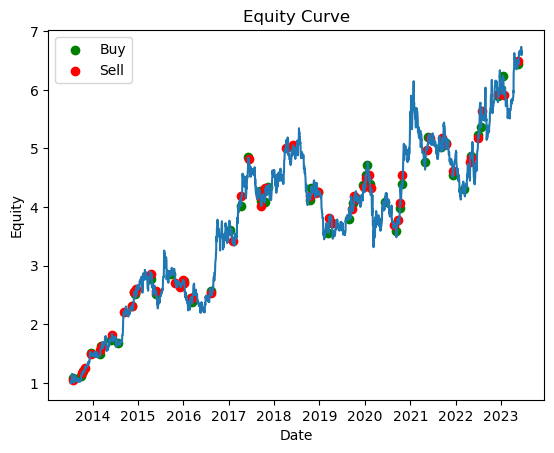

In [6]:
# Plot equity curve
equity_curve = np.cumprod(1 + np.array(returns))
plt.plot(df.index[1:len(equity_curve)+1], equity_curve)

buy_indices = np.where(df.index.isin(buy_dates))[0]
sell_indices = np.where(df.index.isin(sell_dates))[0]

# Adjust the sell indices to match the length of the equity curve
sell_indices = sell_indices[sell_indices < len(equity_curve)]

plt.scatter(df.index[buy_indices], equity_curve[buy_indices], color='green', label='Buy')
plt.scatter(df.index[sell_indices], equity_curve[sell_indices], color='red', label='Sell')


plt.xlabel('Date')
plt.ylabel('Equity')
plt.title('Equity Curve')
plt.legend()
plt.show()

In [7]:
# Calculate evaluation metrics
cumulative_returns = (capital - 100000) / 100000
max_drawdown = np.min(np.subtract.accumulate(returns))
daily_returns = np.array(returns)
sharpe_ratio = np.sqrt(252) * np.mean(daily_returns) / np.std(daily_returns)

# Print evaluation metrics
print('Cumulative Returns:', cumulative_returns)
print('Maximum Drawdown:', max_drawdown)
print('Sharpe Ratio:', sharpe_ratio)

Cumulative Returns: 0.04677453731328584
Maximum Drawdown: -2.2663164972797163
Sharpe Ratio: 0.849428496489007
